In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Data Loading

In [3]:
# Load the survey data
df = pd.read_stata('ZA10000_v2-0-0/ZA10000_v2-0-0.dta')

# Load variable descriptions
with open('data/2022/ZA10000_variables_short.json', 'r') as f:
    variables = json.load(f)

# Load country mapping
with open('data/2022/country.json', 'r') as f:
    country_data = json.load(f)

print(f"Total records: {len(df):,}")
print(f"Total variables: {len(df.columns)}")

Total records: 45,762
Total variables: 417


In [14]:
df

,studyno,version,doi,country,c_sample,c_alphan,v1,v2,v3,v4,...,DATEDY,INTLANG,DWEIGHT_HH,DWEIGHT_TS,DWEIGHT_COM,PSWEIGHT,WEIGHT_COM,MODE,PARTIALS,country_name
0,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,5. Strongly disagree,5. Strongly disagree,...,28,11. German (deu),1.210093,1. No weighting,1.210093,0.627508,0.170447,"50. CAWI, self-completion, web questionnaire",1. Complete case,Austria
1,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,4. Disagree,1. Strongly agree,2. Agree,2. Agree,...,5,11. German (deu),1.210093,1. No weighting,1.210093,1.529463,0.85329,"50. CAWI, self-completion, web questionnaire",1. Complete case,Austria
2,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,4. Disagree,1. Strongly agree,1. Strongly agree,2. Agree,...,30,11. German (deu),1.649203,1. No weighting,1.649203,2.394,3.139915,"50. CAWI, self-completion, web questionnaire",1. Complete case,Austria
3,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,5. Strongly disagree,2. Agree,2. Agree,1. Strongly agree,...,5,11. German (deu),1.649203,1. No weighting,1.649203,1.057297,2.905909,"50. CAWI, self-completion, web questionnaire",1. Complete case,Austria
4,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,4. Disagree,5. Strongly disagree,...,5,11. German (deu),0.675291,1. No weighting,0.675291,0.460084,0.530512,"50. CAWI, self-completion, web questionnaire",1. Complete case,Austria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45757,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,4. Disagree,2. Agree,3. Neither agree nor disagree,1. Strongly agree,...,25,50. Tsonga (tso),0.608397,1. No weighting,0.608397,1. No weighting,0.359394,"24. CAPI, interpreter or translator- visuals",1. Complete case,South Africa
45758,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,2. Agree,4. Disagree,4. Disagree,2. Agree,...,25,12. English (eng),1.82519,1. No weighting,1.82519,1. No weighting,1.813437,"24. CAPI, interpreter or translator- visuals",1. Complete case,South Africa
45759,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,2. Agree,4. Disagree,2. Agree,1. Strongly agree,...,25,50. Tsonga (tso),1.216794,1. No weighting,1.216794,1. No weighting,0.871546,"24. CAPI, interpreter or translator- visuals",1. Complete case,South Africa
45760,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,2. Agree,4. Disagree,4. Disagree,2. Agree,...,25,52. Venda (ven),0.608397,1. No weighting,0.608397,1. No weighting,0.35261,"24. CAPI, interpreter or translator- visuals",1. Complete case,South Africa


In [4]:
# Map country codes to names
df['country_name'] = df['c_alphan'].map(country_data)

# Filter for women only
df_women = df[df['SEX'] == 'Female'].copy()
print(f"Total female respondents: {len(df_women):,}")

# Filter for women with partners
df_women_partnered = df_women[df_women['PARTLIV'] == 'Yes'].copy()
print(f"Female respondents with partners: {len(df_women_partnered):,}")

Total female respondents: 0
Female respondents with partners: 0


## 2. Key Variables Definition

### Partner's Practical Support Variables:
- **v34, v35**: Respondent's hours on household work and family care
- **v36, v37**: Partner's hours on household work and family care
- **v38**: Income sharing between partners
- **v39-v44**: Division of specific household tasks
- **v45**: Overall sharing of household work
- **SPWORK**: Partner's employment status
- **SPWRKHRS**: Partner's work hours
- **WORK**: Respondent's employment status
- **WRKHRS**: Respondent's work hours

In [5]:
# Define key variables for analysis
practical_support_vars = {
    'v34': 'Hours: R on household work',
    'v35': 'Hours: R on family care',
    'v36': 'Hours: Partner on household work',
    'v37': 'Hours: Partner on family care',
    'v38': 'Income sharing',
    'v39': 'Division: Laundry',
    'v40': 'Division: Plan activities',
    'v41': 'Division: Care for sick',
    'v42': 'Division: Shop groceries',
    'v43': 'Division: Cleaning',
    'v44': 'Division: Prepare meals',
    'v45': 'Overall household work sharing',
    'SPWORK': 'Partner employment status',
    'SPWRKHRS': 'Partner work hours',
    'WORK': 'R employment status',
    'WRKHRS': 'R work hours'
}

# Print variable descriptions
print("Variable Descriptions:")
for var, desc in practical_support_vars.items():
    if var in variables:
        print(f"{var}: {variables[var]}")

Variable Descriptions:
v34: Q15a How many hours spend on household work
v35: Q15b How many hours spend on family members
v36: Q16a How many hours spouse, partner works on household
v37: Q16b How many hrs spouse, partner spends on family members
v38: Q17 Sharing of income between partners
v39: Q18a Division of household work: doing the laundry
v40: Q18b Division of household work: plan social/family activities
v41: Q18c Division of household work: care for sick family members
v42: Q18d Division of household work: shops for groceries
v43: Q18e Division of household work: household cleaning
v44: Q18f Division of household work: preparing meals
v45: Q19 Sharing of household work between partners
SPWORK: Spouse, partner: currently, formerly or never in paid work
SPWRKHRS: Spouse, partner: hours worked weekly
WORK: Currently, formerly, or never in paid work
WRKHRS: Hours worked weekly


## 3. Data Exploration and Cleaning

In [6]:
# Check missing values in key variables
key_vars = list(practical_support_vars.keys())
missing_data = df_women_partnered[key_vars].isnull().sum()
missing_pct = (missing_data / len(df_women_partnered) * 100).round(2)

missing_df = pd.DataFrame({
    'Variable': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

print("Missing Data Analysis:")
print(missing_df)

Missing Data Analysis:
    Variable  Missing Count  Missing %
0        v34              0        NaN
1        v35              0        NaN
2        v36              0        NaN
3        v37              0        NaN
4        v38              0        NaN
5        v39              0        NaN
6        v40              0        NaN
7        v41              0        NaN
8        v42              0        NaN
9        v43              0        NaN
10       v44              0        NaN
11       v45              0        NaN
12    SPWORK              0        NaN
13  SPWRKHRS              0        NaN
14      WORK              0        NaN
15    WRKHRS              0        NaN


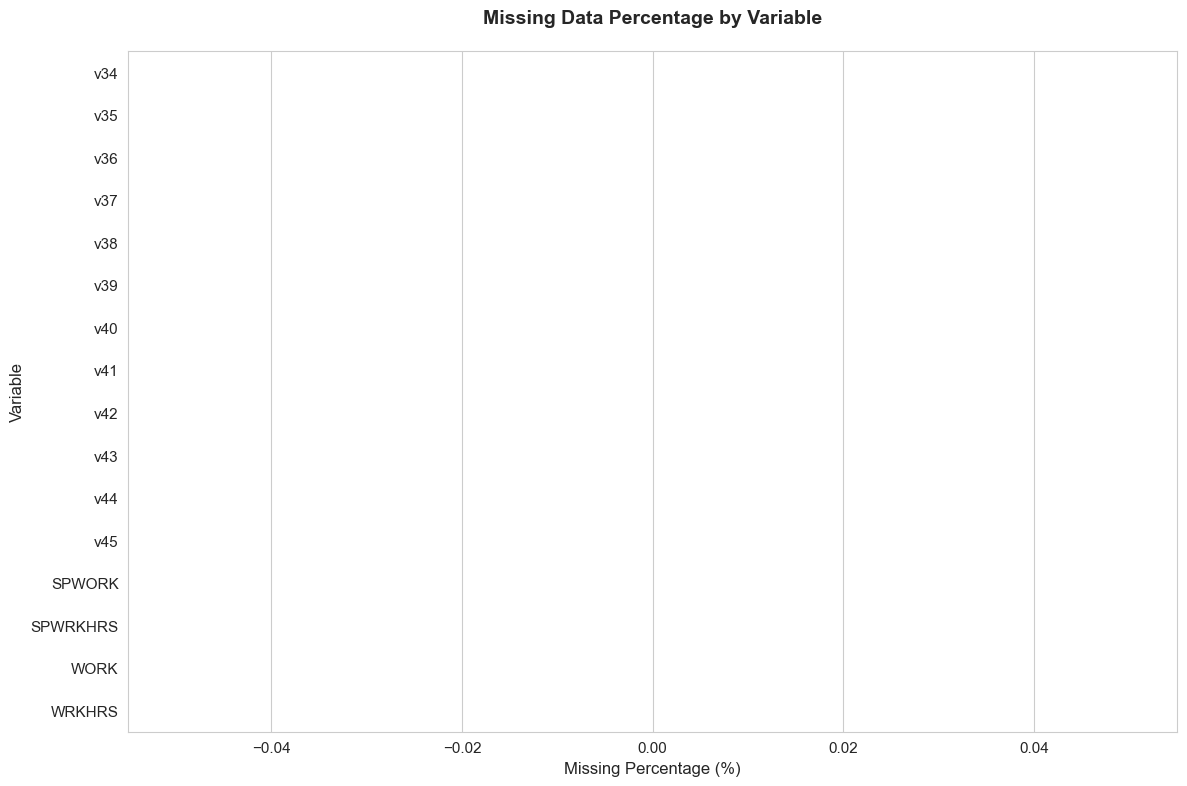

In [7]:
# Visualize missing data
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=missing_df, y='Variable', x='Missing %', palette='viridis', ax=ax)
ax.set_title('Missing Data Percentage by Variable', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Analysis: Time Allocation (Household Work and Family Care)

In [8]:
# Create a clean dataset for time analysis
time_vars = ['v34', 'v35', 'v36', 'v37', 'WORK', 'WRKHRS', 'SPWORK', 'SPWRKHRS']
df_time = df_women_partnered[time_vars + ['country_name']].copy()

# Convert categorical to numeric where needed
# Note: The actual data types will determine the conversion needed
print("\nData types:")
print(df_time.dtypes)

print("\nSample values:")
print(df_time.head(10))


Data types:
v34             category
v35             category
v36             category
v37             category
WORK            category
WRKHRS          category
SPWORK          category
SPWRKHRS        category
country_name      object
dtype: object

Sample values:
Empty DataFrame
Columns: [v34, v35, v36, v37, WORK, WRKHRS, SPWORK, SPWRKHRS, country_name]
Index: []


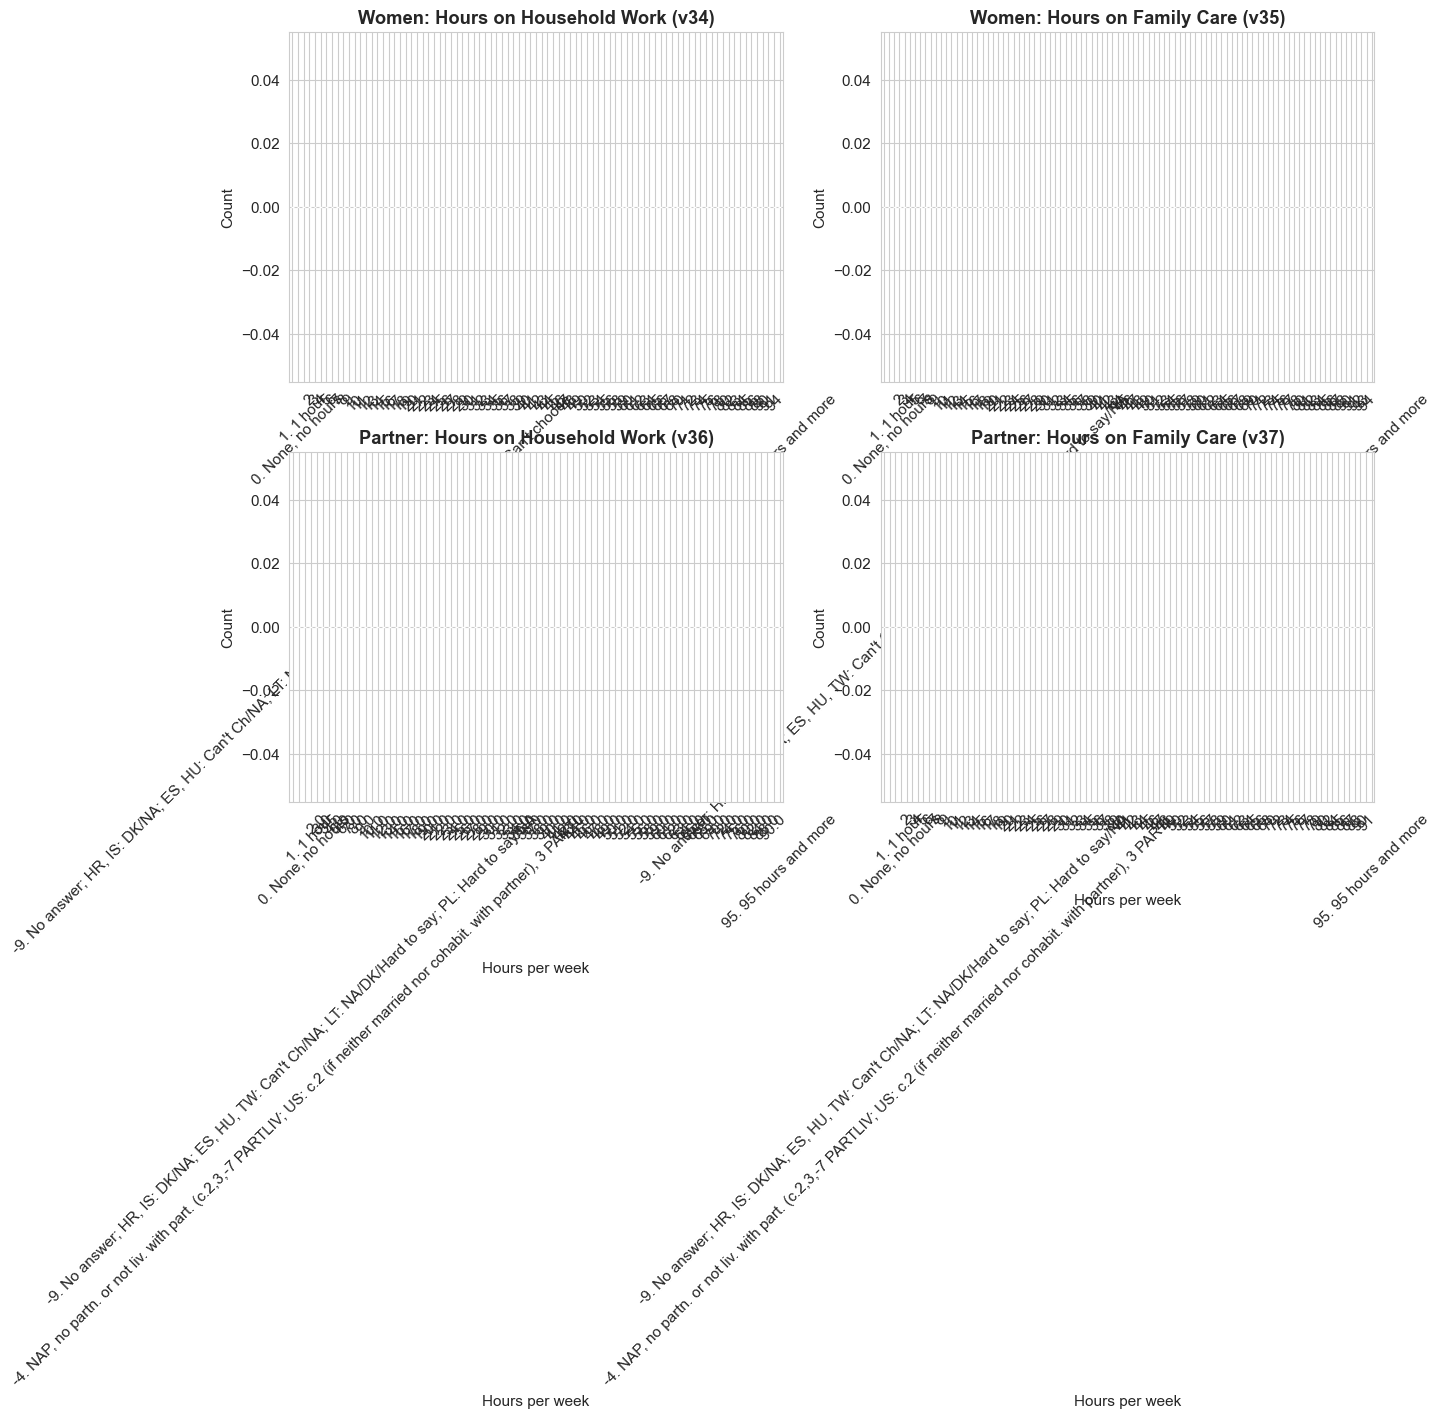

In [15]:
# Distribution of time spent on household work
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R's household work hours
df_time['v34'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='coral')
axes[0, 0].set_title('Women: Hours on Household Work (v34)', fontweight='bold')
axes[0, 0].set_xlabel('Hours per week')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# R's family care hours
df_time['v35'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1], color='lightblue')
axes[0, 1].set_title('Women: Hours on Family Care (v35)', fontweight='bold')
axes[0, 1].set_xlabel('Hours per week')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Partner's household work hours
df_time['v36'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Partner: Hours on Household Work (v36)', fontweight='bold')
axes[1, 0].set_xlabel('Hours per week')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Partner's family care hours
df_time['v37'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Partner: Hours on Family Care (v37)', fontweight='bold')
axes[1, 1].set_xlabel('Hours per week')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Analysis: Partner Support vs. Women's Employment Status

In [10]:
# Women's employment status distribution
work_status_counts = df_women_partnered['WORK'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
work_status_counts.plot(kind='barh', color='steelblue', ax=ax)
ax.set_title('Women\'s Employment Status Distribution', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Employment Status', fontsize=12)

# Add value labels
for i, v in enumerate(work_status_counts.values):
    ax.text(v + 50, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nEmployment Status Breakdown:")
print(work_status_counts)
print(f"\nPercentage: {(work_status_counts / work_status_counts.sum() * 100).round(2)}")


Employment Status Breakdown:
WORK
-9. No answer                                           0
1. Currently in paid work,                              0
2. Currently not in paid work, paid work in the past    0
3. Never had paid work                                  0
Name: count, dtype: int64

Percentage: WORK
-9. No answer                                          NaN
1. Currently in paid work,                             NaN
2. Currently not in paid work, paid work in the past   NaN
3. Never had paid work                                 NaN
Name: count, dtype: float64


In [19]:
# Create binary employment variable (working vs not working)
df_women_partnered['is_working'] = df_women_partnered['WORK'].apply(
    lambda x: 1 if x in ['Currently in paid work'] else 0
)

print(f"Working women: {df_women_partnered['is_working'].sum():,}")
print(f"Not working women: {(len(df_women_partnered) - df_women_partnered['is_working'].sum()):,}")

TypeError: 'Categorical' with dtype category does not support reduction 'sum'

## 6. Key Analysis: Partner's Household Contribution vs. Women's Employment

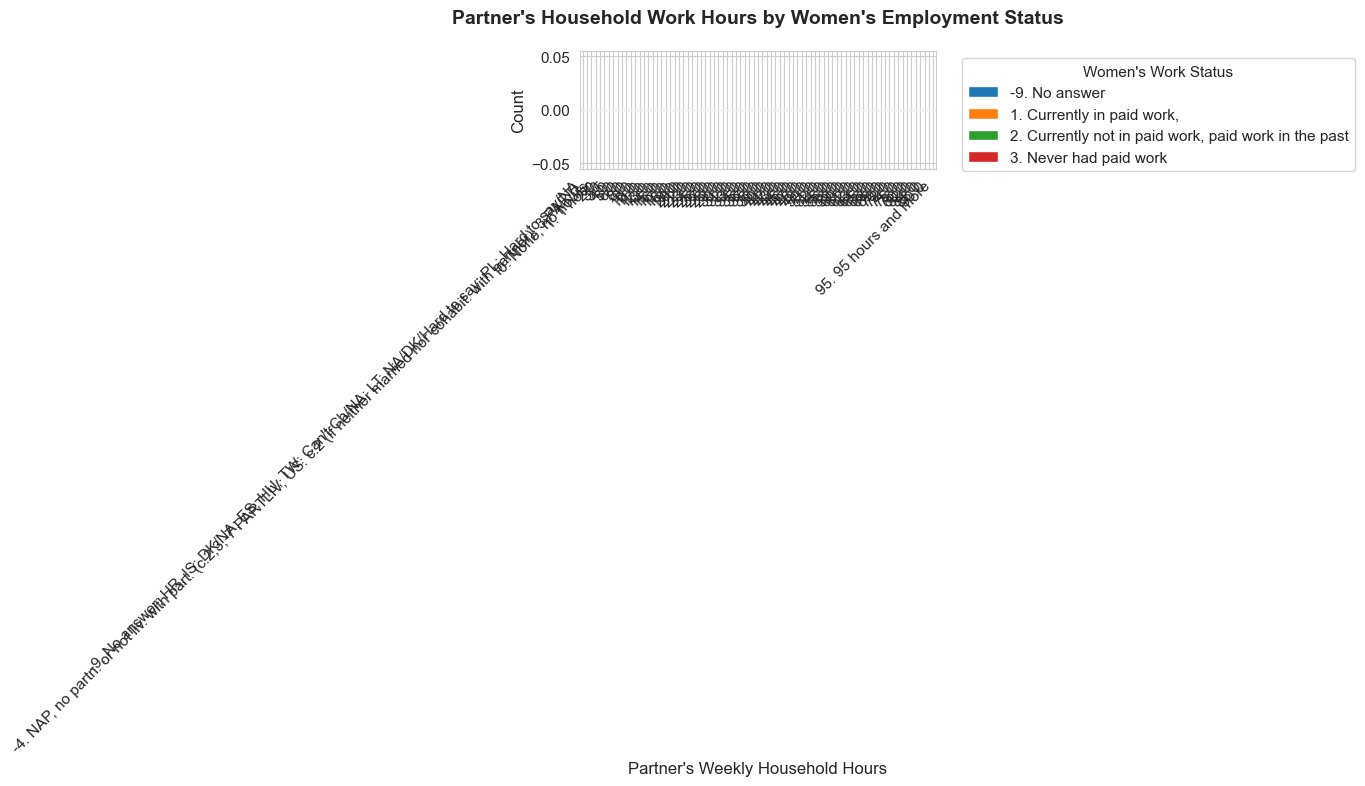

In [17]:
# Analyze partner's household hours by women's employment status
work_groups = df_women_partnered.groupby('WORK')['v36'].value_counts().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))
work_groups.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Partner\'s Household Work Hours by Women\'s Employment Status', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Partner\'s Weekly Household Hours', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend(title='Women\'s Work Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# Average partner support by women's work status
avg_support = df_women_partnered.groupby('WORK')[['v36', 'v37']].apply(
    lambda x: x.apply(pd.to_numeric, errors='coerce').mean()
)

print("Average Partner Support by Women's Employment Status:")
print("\nPartner's Household Work Hours (v36):")
print(avg_support['v36'])
print("\nPartner's Family Care Hours (v37):")
print(avg_support['v37'])

TypeError: 'Categorical' with dtype category does not support reduction 'mean'

## 7. Division of Household Tasks Analysis

In [ ]:
# Analyze division of specific household tasks
task_vars = ['v39', 'v40', 'v41', 'v42', 'v43', 'v44']
task_names = ['Laundry', 'Plan Activities', 'Care for Sick', 'Shop Groceries', 'Cleaning', 'Prepare Meals']

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (var, name) in enumerate(zip(task_vars, task_names)):
    task_dist = df_women_partnered[var].value_counts().sort_index()
    task_dist.plot(kind='barh', ax=axes[idx], color=sns.color_palette('Set2')[idx])
    axes[idx].set_title(f'{name} ({var})', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel('Division')
    
    # Add percentage labels
    total = task_dist.sum()
    for i, v in enumerate(task_dist.values):
        pct = v / total * 100
        axes[idx].text(v + total*0.01, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.suptitle('Division of Household Tasks in Partnered Relationships', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Overall Household Work Sharing Analysis (v45)

In [ ]:
# Overall household work sharing
sharing_dist = df_women_partnered['v45'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
sharing_dist.plot(kind='barh', ax=ax1, color='teal')
ax1.set_title('Overall Household Work Sharing (v45)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Sharing Pattern', fontsize=12)

for i, v in enumerate(sharing_dist.values):
    ax1.text(v + 50, i, str(v), va='center', fontweight='bold')

# Pie chart
colors = sns.color_palette('pastel')
sharing_dist.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Distribution of Household Work Sharing', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 9. Household Work Sharing by Women's Employment Status

In [ ]:
# Cross-tabulation: household sharing vs women's work status
sharing_by_work = pd.crosstab(
    df_women_partnered['v45'], 
    df_women_partnered['WORK'],
    normalize='columns'
) * 100

print("Household Work Sharing by Women's Employment Status (% within each work status):")
print(sharing_by_work.round(2))

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
sharing_by_work.T.plot(kind='bar', ax=ax, width=0.8, colormap='viridis')
ax.set_title('Household Work Sharing Patterns by Women\'s Employment Status', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Women\'s Employment Status', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.legend(title='Sharing Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 10. Partner's Employment Status Analysis

In [ ]:
# Partner's work status distribution
partner_work = df_women_partnered['SPWORK'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
partner_work.plot(kind='barh', color='mediumpurple', ax=ax)
ax.set_title('Partner\'s Employment Status Distribution', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Employment Status', fontsize=12)

for i, v in enumerate(partner_work.values):
    ax.text(v + 50, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Cross-tabulation: Women's work vs Partner's work
dual_employment = pd.crosstab(
    df_women_partnered['WORK'],
    df_women_partnered['SPWORK'],
    margins=True
)

print("Cross-tabulation: Women's Employment vs Partner's Employment")
print(dual_employment)

# Calculate percentages
dual_employment_pct = pd.crosstab(
    df_women_partnered['WORK'],
    df_women_partnered['SPWORK'],
    normalize='index'
) * 100

print("\nPercentage (within each women's work status):")
print(dual_employment_pct.round(2))

## 11. Work Hours Analysis

In [ ]:
# Analyze work hours for working women and their partners
working_women = df_women_partnered[df_women_partnered['WORK'] == 'Currently in paid work'].copy()

print(f"Working women with partners: {len(working_women):,}")
print(f"\nWomen's work hours summary:")
print(working_women['WRKHRS'].describe())
print(f"\nPartner's work hours summary:")
print(working_women['SPWRKHRS'].describe())

In [ ]:
# Scatter plot: Women's work hours vs Partner's household work hours
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Convert to numeric for plotting
working_women['WRKHRS_num'] = pd.to_numeric(working_women['WRKHRS'], errors='coerce')
working_women['v36_num'] = pd.to_numeric(working_women['v36'], errors='coerce')
working_women['v37_num'] = pd.to_numeric(working_women['v37'], errors='coerce')

# Plot 1: Work hours vs Partner's household hours
clean_data1 = working_women[['WRKHRS_num', 'v36_num']].dropna()
axes[0].scatter(clean_data1['WRKHRS_num'], clean_data1['v36_num'], alpha=0.5, color='coral')
axes[0].set_xlabel('Women\'s Work Hours per Week', fontsize=12)
axes[0].set_ylabel('Partner\'s Household Work Hours', fontsize=12)
axes[0].set_title('Women\'s Work Hours vs Partner\'s Household Contribution', 
                  fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add trend line
z1 = np.polyfit(clean_data1['WRKHRS_num'], clean_data1['v36_num'], 1)
p1 = np.poly1d(z1)
axes[0].plot(clean_data1['WRKHRS_num'].sort_values(), 
             p1(clean_data1['WRKHRS_num'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label='Trend')
axes[0].legend()

# Plot 2: Work hours vs Partner's family care hours
clean_data2 = working_women[['WRKHRS_num', 'v37_num']].dropna()
axes[1].scatter(clean_data2['WRKHRS_num'], clean_data2['v37_num'], alpha=0.5, color='skyblue')
axes[1].set_xlabel('Women\'s Work Hours per Week', fontsize=12)
axes[1].set_ylabel('Partner\'s Family Care Hours', fontsize=12)
axes[1].set_title('Women\'s Work Hours vs Partner\'s Family Care', 
                  fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

# Add trend line
z2 = np.polyfit(clean_data2['WRKHRS_num'], clean_data2['v37_num'], 1)
p2 = np.poly1d(z2)
axes[1].plot(clean_data2['WRKHRS_num'].sort_values(), 
             p2(clean_data2['WRKHRS_num'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label='Trend')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calculate correlations
corr1 = clean_data1['WRKHRS_num'].corr(clean_data1['v36_num'])
corr2 = clean_data2['WRKHRS_num'].corr(clean_data2['v37_num'])
print(f"\nCorrelation (Women's work hours vs Partner's household hours): {corr1:.3f}")
print(f"Correlation (Women's work hours vs Partner's family care hours): {corr2:.3f}")

## 12. Income Sharing Analysis (v38)

In [ ]:
# Income sharing patterns
income_sharing = df_women_partnered['v38'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
income_sharing.plot(kind='barh', ax=axes[0], color='gold')
axes[0].set_title('Income Sharing Patterns (v38)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Sharing Arrangement', fontsize=12)

for i, v in enumerate(income_sharing.values):
    axes[0].text(v + 50, i, str(v), va='center', fontweight='bold')

# Pie chart
income_sharing.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                    colors=sns.color_palette('Set3'), startangle=90)
axes[1].set_title('Distribution of Income Sharing', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Income sharing by women's employment status
income_by_work = pd.crosstab(
    df_women_partnered['v38'],
    df_women_partnered['WORK'],
    normalize='columns'
) * 100

print("Income Sharing by Women's Employment Status (% within each work status):")
print(income_by_work.round(2))

fig, ax = plt.subplots(figsize=(14, 8))
income_by_work.T.plot(kind='bar', ax=ax, width=0.8, colormap='Spectral')
ax.set_title('Income Sharing Patterns by Women\'s Employment Status', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Women\'s Employment Status', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.legend(title='Income Sharing', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 13. Country-Level Comparison

In [ ]:
# Women's employment rate by country
country_employment = df_women_partnered.groupby('country_name')['is_working'].agg(['sum', 'count'])
country_employment['employment_rate'] = (country_employment['sum'] / country_employment['count'] * 100).round(2)
country_employment = country_employment.sort_values('employment_rate', ascending=False)

print("Women's Employment Rate by Country (Top 15):")
print(country_employment[['employment_rate', 'count']].head(15))

# Plot top 15 countries
fig, ax = plt.subplots(figsize=(12, 8))
country_employment['employment_rate'].head(15).plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Women\'s Employment Rate by Country (Top 15)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Employment Rate (%)', fontsize=12)
ax.set_ylabel('Country', fontsize=12)

for i, v in enumerate(country_employment['employment_rate'].head(15).values):
    ax.text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Average partner household support by country (top 10 countries by sample size)
top_countries = df_women_partnered['country_name'].value_counts().head(10).index
df_top_countries = df_women_partnered[df_women_partnered['country_name'].isin(top_countries)].copy()

# Convert to numeric
df_top_countries['v36_num'] = pd.to_numeric(df_top_countries['v36'], errors='coerce')
df_top_countries['v37_num'] = pd.to_numeric(df_top_countries['v37'], errors='coerce')

country_support = df_top_countries.groupby('country_name')[['v36_num', 'v37_num']].mean().sort_values('v36_num', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
country_support.plot(kind='barh', ax=ax, width=0.8)
ax.set_title('Average Partner Support by Country (Top 10 by Sample Size)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Average Hours per Week', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.legend(['Household Work (v36)', 'Family Care (v37)'], loc='lower right')
plt.tight_layout()
plt.show()

## 14. Statistical Testing: Partner Support and Women's Employment

In [ ]:
# Chi-square test: Household work sharing vs Women's employment
contingency_table = pd.crosstab(
    df_women_partnered['v45'].dropna(),
    df_women_partnered.loc[df_women_partnered['v45'].notna(), 'is_working']
)

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square Test: Household Work Sharing vs Women's Employment")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"\nSignificant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

if p_value < 0.05:
    print("\n✓ There is a statistically significant relationship between household work sharing")
    print("  and women's employment status.")
else:
    print("\n✗ No statistically significant relationship found.")

In [ ]:
# T-test: Partner's household hours for working vs non-working women
working_women_v36 = pd.to_numeric(
    df_women_partnered[df_women_partnered['is_working'] == 1]['v36'], 
    errors='coerce'
).dropna()

nonworking_women_v36 = pd.to_numeric(
    df_women_partnered[df_women_partnered['is_working'] == 0]['v36'], 
    errors='coerce'
).dropna()

t_stat, p_value_t = stats.ttest_ind(working_women_v36, nonworking_women_v36)

print("\nT-Test: Partner's Household Hours (v36) - Working vs Non-Working Women")
print(f"Working women - Partner's avg household hours: {working_women_v36.mean():.2f}")
print(f"Non-working women - Partner's avg household hours: {nonworking_women_v36.mean():.2f}")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_t:.4f}")
print(f"\nSignificant at α=0.05: {'Yes' if p_value_t < 0.05 else 'No'}")

if p_value_t < 0.05:
    if working_women_v36.mean() > nonworking_women_v36.mean():
        print("\n✓ Partners of working women contribute significantly MORE household hours.")
    else:
        print("\n✓ Partners of working women contribute significantly LESS household hours.")
else:
    print("\n✗ No significant difference in partner's household contribution.")

## 15. Key Findings and Insights

In [ ]:
# Summary statistics
print("="*80)
print("KEY FINDINGS: Partner's Practical Support and Women's Employability")
print("="*80)

print("\n1. SAMPLE OVERVIEW")
print(f"   - Total female respondents with partners: {len(df_women_partnered):,}")
print(f"   - Working women: {df_women_partnered['is_working'].sum():,} ({df_women_partnered['is_working'].mean()*100:.1f}%)")
print(f"   - Countries represented: {df_women_partnered['country_name'].nunique()}")

print("\n2. TIME ALLOCATION")
working_v36 = pd.to_numeric(df_women_partnered[df_women_partnered['is_working']==1]['v36'], errors='coerce').mean()
working_v37 = pd.to_numeric(df_women_partnered[df_women_partnered['is_working']==1]['v37'], errors='coerce').mean()
print(f"   - Partner's household work (working women): {working_v36:.2f} hrs/week")
print(f"   - Partner's family care (working women): {working_v37:.2f} hrs/week")

print("\n3. HOUSEHOLD WORK SHARING")
most_common_sharing = df_women_partnered['v45'].value_counts().head(3)
print("   Top 3 sharing patterns:")
for idx, (pattern, count) in enumerate(most_common_sharing.items(), 1):
    pct = count / len(df_women_partnered[df_women_partnered['v45'].notna()]) * 100
    print(f"   {idx}. {pattern}: {count:,} ({pct:.1f}%)")

print("\n4. DUAL EMPLOYMENT")
both_working = len(df_women_partnered[
    (df_women_partnered['is_working'] == 1) & 
    (df_women_partnered['SPWORK'] == 'Currently in paid work')
])
dual_pct = both_working / len(df_women_partnered) * 100
print(f"   - Dual-earner couples: {both_working:,} ({dual_pct:.1f}%)")

print("\n5. STATISTICAL SIGNIFICANCE")
print(f"   - Household sharing vs Employment: {'Significant' if p_value < 0.05 else 'Not significant'} (p={p_value:.4f})")
print(f"   - Partner's hours difference: {'Significant' if p_value_t < 0.05 else 'Not significant'} (p={p_value_t:.4f})")

print("\n" + "="*80)

## 16. Conclusions

### Research Question: What is the role of the partner in women's employability?

Based on the analysis of practical support variables, we can draw several conclusions:

1. **Time Allocation Matters**: The analysis reveals how partners' time investment in household work and family care relates to women's employment status.

2. **Division of Labor Patterns**: The distribution of specific household tasks shows gendered patterns that may enable or constrain women's employment.

3. **Dual Employment Dynamics**: Partner's employment status correlates with women's work participation, suggesting interdependence in employment decisions.

4. **Work Hours Relationship**: There appears to be a relationship between women's work hours and their partners' household contributions.

5. **Income Sharing Arrangements**: How couples manage finances may reflect and influence women's employment patterns.

6. **Cross-Country Variation**: Significant differences across countries suggest cultural and policy factors mediate partner support effects.

### Policy Implications:
- Promoting equitable household work division may support women's employment
- Flexible work arrangements for both partners could facilitate dual employment
- Childcare support and parental leave policies affect how partner support translates to women's employability

### Limitations:
- Cross-sectional data limits causal inference
- Self-reported time estimates may have bias
- Missing data in some variables
- Cultural differences in survey interpretation

### Future Research:
- Longitudinal analysis to establish causality
- Examine interaction effects with policy variables
- Include attitude variables (v1-v6) for comprehensive understanding
- Analyze work-life balance measures (v46-v49)